In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from tqdm.notebook import tqdm

from xgboost import plot_importance, plot_tree

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
import random
plt.style.use('fivethirtyeight')

In [2]:
# Time sequence length and prediction time length
seed = 55688
time_seq = 10
predict_t = 3
valid_ratio = 0.2
task = 'classification'

In [3]:
# Setup seed
random.seed(seed)

# Get GPU
device_count = torch.cuda.device_count()
num_of_gpus = device_count

for i in range(device_count):
    print("GPU {}: {}".format(i, torch.cuda.get_device_name(i)))
    gpu_id = i

# Save best model to 
save_path = "../model"

# Define DataSet
dirname = "../data/single"
dir_list = os.listdir(dirname)
# dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) ) ]

train_dates = ['03-26', '04-01']
test_dates = ['04-10']

GPU 0: NVIDIA GeForce RTX 4070 Ti
GPU 1: NVIDIA GeForce RTX 4070 Ti


In [4]:


def days_in_file(file, dates):
    
    for date in dates:
        if date in file: return True 
    return False

def train_valid_split(L, valid_size=0.2):
    
    length = len(L)
    v_num = int(length*valid_size)
    v_files = random.sample(L, v_num)
    t_files = list(set(L) - set(v_files))
    
    return t_files, v_files
    
# train_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, train_dates) )]
# test_dir_list = [f for f in dir_list if ( f.endswith('.csv') and ('All' in f) and days_in_file(f, test_dates) )]

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)


# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2'
#         ]

features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
        'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2'
        ]

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss

In [16]:


def ts_array_create(dir_name, dir_list, time_seq):
  
    def reamin_HO_time(y_train):
        def f(L):
      
            for i, e in enumerate(L):
                if e: return i+1
            return 0

        out = []
        for a2 in y_train:
            a1_out = []
            for a1 in a2:
                a1_out.append(a1.any())
      
            out.append(f(a1_out))
        return out
    
    def HO(y_train):
        out = []
        for a2 in y_train:
            if sum(a2.reshape(-1)) == 0: ho = 0
            elif sum(a2.reshape(-1)) > 0: ho = 1
            out.append(ho)
        return out

    split_time = []
    for i, f in enumerate(tqdm(dir_list)):
    
        f = os.path.join(dirname, f)
        # df = pd.read_csv(f)

        try:
            df = pd.read_csv(f)
        except pd.errors.ParserError as e:
            print(f"An error occurred while reading the file {f}: {e}")
            print(f, '\n')
    
        df.replace(np.nan,0); df.replace('-',0)
        X = df[features]
        Y = df[target]

        Xt_list = []
        Yt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)
    
        for j in range(time_seq,time_seq+predict_t):
            Y_t = Y.shift(periods=-(j))
            Yt_list.append(Y_t)

        YY = Y.shift(periods=-(0))

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq+predict_t-1),:,:];
        Y_ts = np.array(Yt_list); Y_ts = np.transpose(Y_ts, (1,0,2)); Y_ts = Y_ts[:-(time_seq+predict_t-1),:,:];
        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = Y_ts
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,Y_ts), axis=0)

    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]

    if task == 'classification':
        return X_final, HO(Y_final), split_time # classification
    elif task == 'forecast':
        return X_final, reamin_HO_time(Y_final), split_time # forecast HO
#         return X_final, np.sum(Y_final, axis=1), split_time # forecase loss

In [ ]:
!pip install notebook --upgrade

In [17]:
!pip install ipywidgets


In [18]:
print('Loading training data...')
X_train, y_train, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)

print('Loading testing data...')
X_test, y_test, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)

train_data = xgb.DMatrix(X_train_2d, label=y_train)
test_data = xgb.DMatrix(X_test_2d, label=y_test)

Loading training data...


  0%|          | 0/283 [00:00<?, ?it/s]

/tmp/ipykernel_1597292/2777473071.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(np.nan,0); df.replace('-',0)
/tmp/ipykernel_1597292/2777473071.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(np.nan,0); df.replace('-',0)
/tmp/ipykernel_1597292/2777473071.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fut

An error occurred while reading the file ../data/single/2023-06-12_sm00_#02_All(wo_B1).csv: Error tokenizing data. C error: Expected 30 fields in line 36, saw 49



/tmp/ipykernel_1597292/2777473071.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(np.nan,0); df.replace('-',0)
/tmp/ipykernel_1597292/2777473071.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(np.nan,0); df.replace('-',0)
/tmp/ipykernel_1597292/2777473071.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('fut

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [5]:
X_train.shape

(39627, 10, 20)

In [6]:
if task == 'forecast':
    params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'max_depth': 20, 'eval_metric': ['rmse', 'mae'], 'seed': seed}
elif task == 'classification':
    params = {'objective': 'binary:logistic', "tree_method": "gpu_hist", 'max_depth': 6, 'eta': 0.1} # 'eval_metric': ['auc', 'aucpr']}
n = 300

In [7]:
params

{'objective': 'binary:logistic',
 'tree_method': 'gpu_hist',
 'max_depth': 6,
 'eta': 0.1}

In [8]:
model = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=n,
    evals=[(train_data, 'train'), (test_data, 'valid')],
)


[0]	train-logloss:0.64142	valid-logloss:0.64261
[1]	train-logloss:0.59868	valid-logloss:0.60086
[2]	train-logloss:0.56282	valid-logloss:0.56646
[3]	train-logloss:0.53223	valid-logloss:0.53702
[4]	train-logloss:0.50623	valid-logloss:0.51226
[5]	train-logloss:0.48411	valid-logloss:0.49097
[6]	train-logloss:0.46479	valid-logloss:0.47253
[7]	train-logloss:0.44770	valid-logloss:0.45688
[8]	train-logloss:0.43305	valid-logloss:0.44312
[9]	train-logloss:0.42004	valid-logloss:0.43143
[10]	train-logloss:0.40859	valid-logloss:0.42079
[11]	train-logloss:0.39854	valid-logloss:0.41156
[12]	train-logloss:0.38930	valid-logloss:0.40369
[13]	train-logloss:0.38092	valid-logloss:0.39634
[14]	train-logloss:0.37364	valid-logloss:0.39012
[15]	train-logloss:0.36716	valid-logloss:0.38433
[16]	train-logloss:0.36120	valid-logloss:0.37926
[17]	train-logloss:0.35588	valid-logloss:0.37456
[18]	train-logloss:0.35110	valid-logloss:0.37072
[19]	train-logloss:0.34639	valid-logloss:0.36668
[20]	train-logloss:0.34139	val

In [9]:
preds = model.predict(test_data)

Acc: 88.08103661044836; precision: 0.72; recall:0.42; f1:0.53


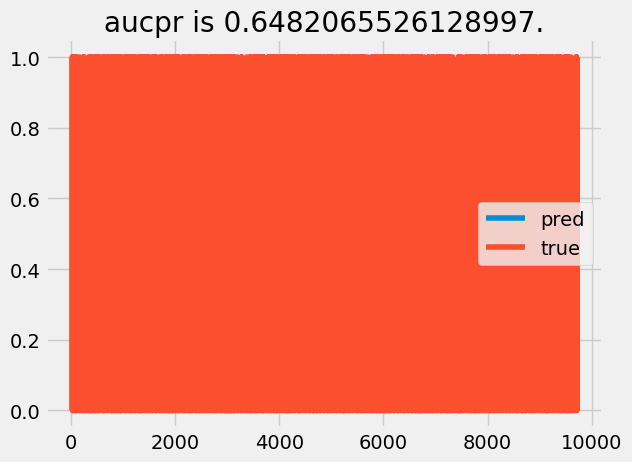

In [10]:
# plot all data point on a plot
if task == 'forecast':
    rmse = round(np.sqrt(np.mean((preds-y_test)**2)), 2)
    plt.title(f'RMSE is {rmse}.')
elif task == 'classification':
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    aucpr = auc(recall, precision)
    anses = np.where(preds<0.5, 0, 1)
    TP, FP, TN, FN = 0,0,0,0
    for ans, y in zip(anses, y_test):
        if ans == y:
            if ans == 1: TP += 1
            elif ans == 0: TN +=1
        elif ans != y:
            if ans == 1: FP += 1
            elif ans == 0: FN +=1
    acc=(TP+TN)/(TP+TN+FP+FN)*100
    try:
        precision, recall = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
        f1 = round(2*(precision*recall)/(precision+recall), 2)
    except:
        precision, recall, f1 = 'DNF', 'DNF', 'DNF'
    s = f'Acc: {acc}; precision: {precision}; recall:{recall}; f1:{f1}'
    print(s)
    plt.title(f'aucpr is {aucpr}.')

plt.plot(preds[0],label='pred')
plt.plot(y_test,label='true')
plt.legend()
plt.show()

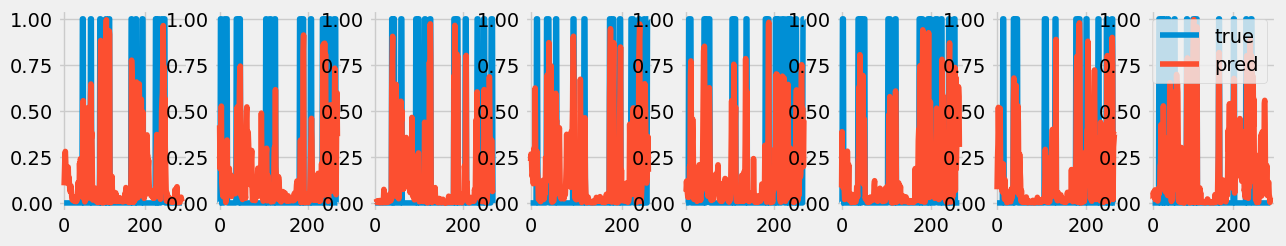

In [11]:
# visulized on many sample on validation data

sample_value = 8
samples = random.sample(split_time_test, sample_value)
fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

# y_test
# preds

for i in range(sample_value):
    true = [y_test[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()

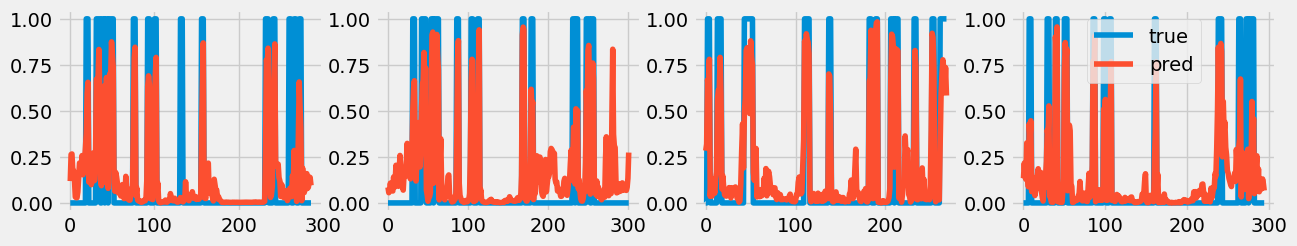

In [12]:
# Check whethet it do good on training data
sample_value = 4
samples = random.sample(split_time_train, sample_value)
preds_train = model.predict(train_data)

fig, axs = plt.subplots(1, sample_value, figsize=(14, 2.5))

for i in range(sample_value):
    true = [y_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(true, label='true')
    prediciton = [preds_train[i] for i in range(samples[i][0], samples[i][1])]
    axs[i].plot(prediciton, label='pred')

plt.legend()

# Debug

Loading training data...


  0%|          | 0/142 [00:00<?, ?it/s]

Loading testing data...


  0%|          | 0/35 [00:00<?, ?it/s]

[0]	train-logloss:0.62040	valid-logloss:0.63748
[1]	train-logloss:0.55952	valid-logloss:0.59234
[2]	train-logloss:0.50732	valid-logloss:0.55328
[3]	train-logloss:0.46202	valid-logloss:0.51916
[4]	train-logloss:0.42216	valid-logloss:0.49034
[5]	train-logloss:0.38697	valid-logloss:0.46553
[6]	train-logloss:0.35554	valid-logloss:0.44452
[7]	train-logloss:0.32761	valid-logloss:0.42584
[8]	train-logloss:0.30233	valid-logloss:0.40864
[9]	train-logloss:0.27975	valid-logloss:0.39364
[10]	train-logloss:0.25933	valid-logloss:0.38024
[11]	train-logloss:0.24069	valid-logloss:0.36847
[12]	train-logloss:0.22389	valid-logloss:0.35807
[13]	train-logloss:0.20829	valid-logloss:0.34911
[14]	train-logloss:0.19458	valid-logloss:0.34103
[15]	train-logloss:0.18207	valid-logloss:0.33433
[16]	train-logloss:0.17053	valid-logloss:0.32828
[17]	train-logloss:0.15998	valid-logloss:0.32258
[18]	train-logloss:0.15020	valid-logloss:0.31717
[19]	train-logloss:0.14138	valid-logloss:0.31290
[20]	train-logloss:0.13327	val

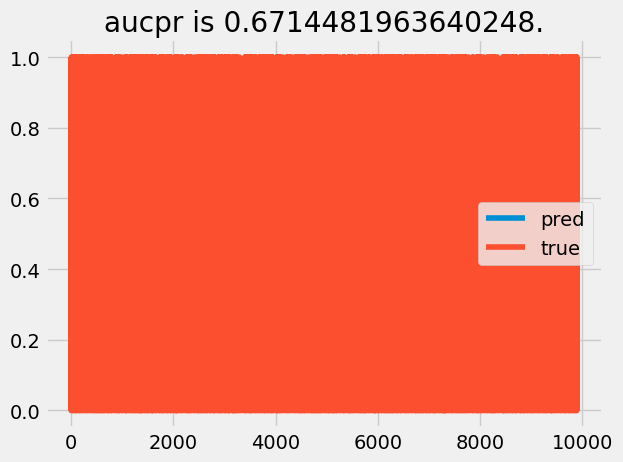

: 

In [13]:
# Time sequence length and prediction time length
seed = 5269
valid_ratio = 0.2

time_seq = 10
predict_t = 3

n = 300
max_depth = 20
eta = 0.1
n_estimators = 100
subsample = 1
colsample_bytree = 1
gamma = 0
task = 'classification'

train_dir_list, test_dir_list = train_valid_split(dir_list, valid_ratio)

# features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
#         'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
#         'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2'
#         ]

# without gNB_Rel, RSRP2, RSRQ2
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1',  
        'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2'
        ]

num_of_features = len(features)

target = ['LTE_HO', 'MN_HO'] # For eNB HO.
# target = ['eNB_to_ENDC'] # Setup gNB
# target = ['gNB_Rel', 'gNB_HO'] # For gNB HO.
# target = ['RLF'] # For RLF
# target = ['SCG_RLF'] # For scg failure
# target = ['dl-loss'] # For DL loss
# target = ['ul-loss'] # For UL loss


print('Loading training data...')
X_train, y_train, split_time_train = ts_array_create(dirname, train_dir_list, time_seq)
X_train_2d = X_train.reshape(-1, time_seq*num_of_features)

print('Loading testing data...')
X_test, y_test, split_time_test = ts_array_create(dirname, test_dir_list, time_seq)
X_test_2d = X_test.reshape(-1, time_seq*num_of_features)

train_data = xgb.DMatrix(X_train_2d, label=y_train)
test_data = xgb.DMatrix(X_test_2d, label=y_test)

if task == 'forecast':
    params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", 'max_depth': max_depth, 'eta': eta, 'n_estimators': n_estimators,
              'subsample': subsample, 'colsample_bytree': colsample_bytree, 'gamma': gamma,
              'eval_metric': ['rmse', 'mae'], 'seed': seed}
elif task == 'classification':
    params = {'objective': 'binary:logistic', "tree_method": "gpu_hist", 'max_depth': max_depth, 'eta': eta,  
              'seed': seed} # 'eval_metric': ['auc', 'aucpr']}

model = xgb.train(
    params=params,
    dtrain=train_data,
    num_boost_round=n,
    evals=[(train_data, 'train'), (test_data, 'valid')],
)

preds = model.predict(test_data)

# plot all data point on a plot
if task == 'forecast':
    rmse = round(np.sqrt(np.mean((preds-y_test)**2)), 2)
    plt.title(f'RMSE is {rmse}.')
elif task == 'classification':
    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    aucpr = auc(recall, precision)
    anses = np.where(preds<0.5, 0, 1)
    TP, FP, TN, FN = 0,0,0,0
    for ans, y in zip(anses, y_test):
        if ans == y:
            if ans == 1: TP += 1
            elif ans == 0: TN +=1
        elif ans != y:
            if ans == 1: FP += 1
            elif ans == 0: FN +=1
    acc=(TP+TN)/(TP+TN+FP+FN)*100
    try:
        precision, recall = round(TP/(TP+FP), 2), round(TP/(TP+FN), 2)
        f1 = round(2*(precision*recall)/(precision+recall), 2)
    except:
        precision, recall, f1 = 'DNF', 'DNF', 'DNF'
    s = f'Acc: {acc}; precision: {precision}; recall:{recall}; f1:{f1}'
    print(s)
    plt.title(f'aucpr is {aucpr}.')

plt.plot(preds[0],label='pred')
plt.plot(y_test,label='true')
plt.legend()
plt.show()